# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, we will implement a Traffic Sign Recognition Classifier, each stage of the implementation will be described as a step by step solution.


In addition to the code implementation, a complete writeup can be found. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

## Imports for the project

In [5]:
#Importing basic libraries for the implementation
import tensorflow as tf
import numpy as np
import random
import cv2
import glob
import tensorflow.contrib.layers as layers
from tqdm import tqdm_notebook
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

---
## Step 0: Load The Data

In [6]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'C:/Users/Fly_Boy/Desktop/Udacity/traffic-signs-data/train.p'
validation_file = 'C:/Users/Fly_Boy/Desktop/Udacity/traffic-signs-data/valid.p'
testing_file    = 'C:/Users/Fly_Boy/Desktop/Udacity/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


###  Basic Summary of the Data Set 

In [7]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("\nImage data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410

Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset


In [8]:
### Data sanity check

#Do we have unlabeled Data ?
assert(None not in y_train)
assert(None not in y_valid)
assert(None not in y_test)

#Are all the label between 43 and 0 ?
assert False in set(y_train > 43)
assert False in set(y_train < 0)

assert False in set(y_valid > 43)
assert False in set(y_valid < 0)

assert False in set(y_test > 43)
assert False in set(y_test < 0)

#Are there as much as label as training image for our train, valid and test set ?
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

Our Dataset has passed our little sanity check , lets explore it further

Here are some sample images from our dataset :


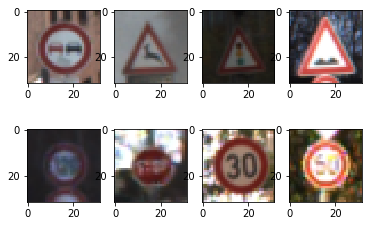

In [9]:
### Data exploration

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# What does the images in our dataset looks like ?
# Lets have a look to some random sample 

print("Here are some sample images from our dataset :")

for i in range(8):
    plt.subplot(2,4,i+1)
    index = random.randint(0, len(X_train))
    plt.imshow(X_train[index])

We have then 34799 image of size (32, 32, 3) that can be used to train a model and categorize trafic signs accros 43 categories

Here is an example image for each of the different category to explore the category further :


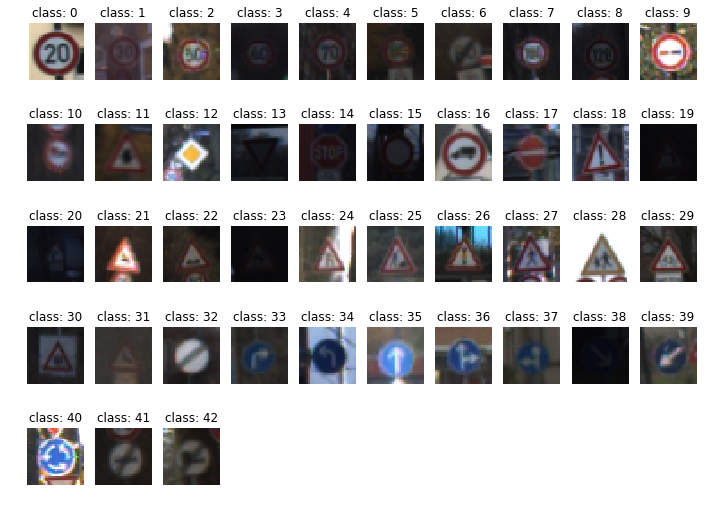

In [8]:
#Problem summary :

print ("We have then" , n_train, "image of size" ,image_shape, "that can be used to train a model and categorize trafic signs accros",n_classes,"categories")
print ("\nHere is an example image for each of the different category to explore the category further :")

fig = plt.figure(figsize=(12, 9))

for i in range(n_classes):
    plt.subplot(5,10,i+1)
    index_list = [x[0] for x in np.where(y_train == i)] 
    index = index_list[0]
    plt.imshow(X_train[index])
    plt.title("class: " + str(y_train[index]))
    plt.axis('off')

[]

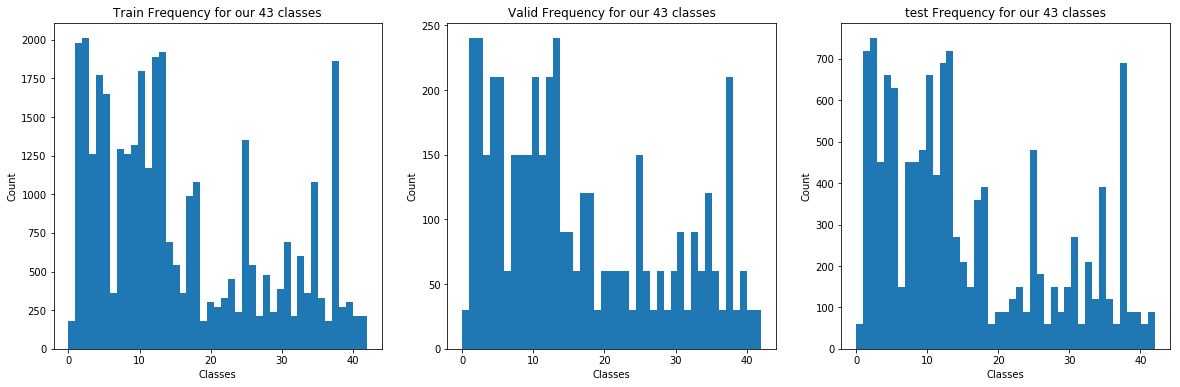

In [9]:
# Lets see how our train data are spread across the different classes?

fig = plt.figure(figsize=(20, 6))

#train
plt.subplot(1,3,1)
plt.hist(y_train, bins=n_classes)
plt.title('Train Frequency for our 43 classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.plot()

#valid
plt.subplot(1,3,2)
plt.hist(y_valid, bins=n_classes)
plt.title('Valid Frequency for our 43 classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.plot()

#test
plt.subplot(1,3,3)
plt.hist(y_test, bins=n_classes)
plt.title('test Frequency for our 43 classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.plot()

It sounds like the dataset is unbalances, some classes have low frequency (<250)
We may want to get more sample for these low frequency classes to enhance the efficiency of our model , data augmentation sounds pretty well adapted here.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-processing the Data Set

Our pre-prossessing pipeline will include Data cleaning , Data augmentation & Data normalizationfor this project

### Data cleaning

Some of the image like the one under are very dark and not so much usefull for our model , lets delete them so as to improve our model performance

(-0.5, 31.5, 31.5, -0.5)

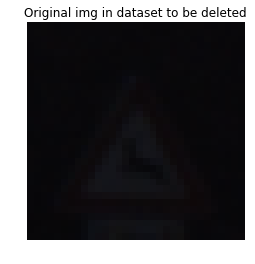

In [10]:
fig = plt.figure(figsize=(6, 4))
plt.title('Original img in dataset to be deleted')
plt.imshow(X_train[335])#335
plt.axis('off')

In [11]:
X_train_cleaned = []
y_train_cleaned = []

print("initial shape : ",X_train.shape)

for i in tqdm_notebook(range(len(X_train))):
    if np.mean(X_train[i])>15:
        X_train_cleaned.append(X_train[i])
        y_train_cleaned.append(y_train[i])

X_train_cleaned = np.array(X_train_cleaned)
y_train_cleaned = np.array(y_train_cleaned)
        
print("Cleaned shape : ",X_train_cleaned.shape)

initial shape :  (34799, 32, 32, 3)


HBox(children=(IntProgress(value=0, max=34799), HTML(value='')))


Cleaned shape :  (34219, 32, 32, 3)


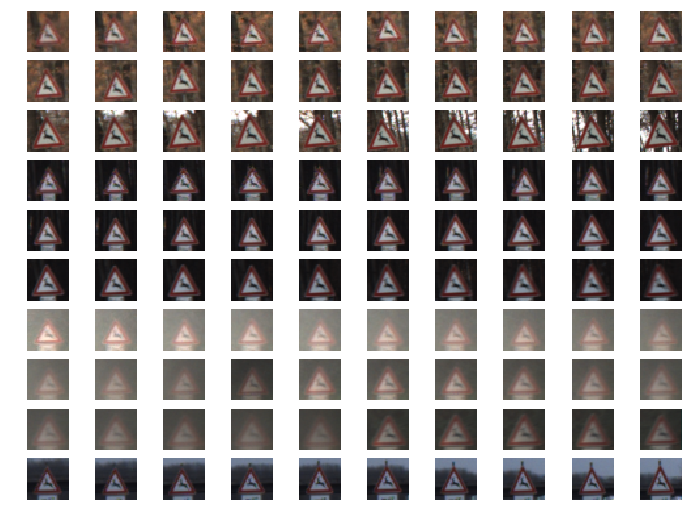

In [13]:
#Allright or dataset should look better now lets have a look
fig = plt.figure(figsize=(12, 9))
plot=1
for i in range(300,400,1):
    plt.subplot(10,10,plot)
    plot+=1
    plt.imshow(X_train_cleaned[i])
    plt.axis('off')
#no more darky images !

### Data Augmentation

In this part we will generate additional training image based on modification on our initial training set , this should help increasing our model accuracy by getting more data to train our model in general but it will also help for category where the training set contain only few images.

In order to augment our training set , we will use OpenCV to do few transformation :

*Image translation changes

*Image Contrast/brightness changes

*Image scaling changes

*Image rotation changes

Ref :https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

In [14]:
# Lets allow random translation up to 2px pixels on both x and y axis 

def random_translate(img):
    
    dx = random.randint(-2, 2)
    dy = random.randint(-2, 2)
    M = np.float32([[1,0,dx],[0,1,dy]])
   
    return cv2.warpAffine(img,M,(32,32))

In [15]:
#Lets allow random contrast/brightness changes

def random_contrast(img):
    
    contrast = random.uniform(1,2)
    brightness = random.randint(1,2)

    return cv2.add(cv2.multiply(img, np.array([contrast])), brightness)   

In [16]:
#Lets allow random increased scaling changes up to 2 px

def random_scaling(img):   
   
    dx = np.random.randint(-2,2)
    pts1 = np.float32([[dx,dx],[32-dx,dx],[dx,32-dx],[32-dx,32-dx]])
    pts2 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(img,M,(32,32))
    return dst
    

In [17]:
#Lets allow small random rotation changes up to 2 degrees

def random_rotation(img):
   
    dO = random.randint(-2, 2)
    M = cv2.getRotationMatrix2D((16,16),dO,1)

    return cv2.warpAffine(img,M,(32,32))

In [18]:
def generate_img(img):
    return random_translate(random_scaling(random_rotation(img))) #skip the brightness for testing improving the results

Lets test our functions

(-0.5, 31.5, 31.5, -0.5)

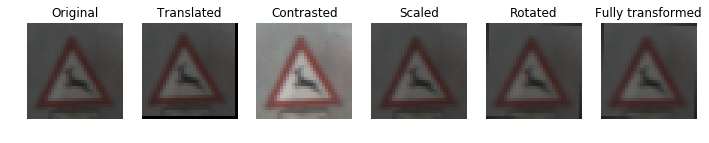

In [19]:
fig = plt.figure(figsize=(12, 8))

img_index=567

plt.subplot(1,6,1)
plt.title('Original')
plt.imshow(X_train_cleaned[img_index])
plt.axis('off')

plt.subplot(1,6,2)
plt.title('Translated')
plt.imshow(random_translate(X_train_cleaned[img_index]))
plt.axis('off')

plt.subplot(1,6,3)
plt.title('Contrasted')
plt.imshow(random_contrast(X_train_cleaned[img_index]))
plt.axis('off')

plt.subplot(1,6,4)
plt.title('Scaled')
plt.imshow(random_scaling(X_train_cleaned[img_index]))
plt.axis('off')

plt.subplot(1,6,5)
plt.title('Rotated')
plt.imshow(random_rotation(X_train_cleaned[img_index]))
plt.axis('off')

plt.subplot(1,6,6)
plt.title('Fully transformed')
plt.imshow(generate_img(X_train_cleaned[img_index]))
plt.axis('off')

#### Generate new images for our training set

In [464]:
X_train_aug = X_train_cleaned
y_train_aug = y_train_cleaned

for category_nb in tqdm_notebook(range(n_classes)):
    
    img_index_for_classe = np.where(y_train_cleaned == category_nb)
    img_nb_for_classe = len(img_index_for_classe[0])
    i=img_nb_for_classe
    #lets generate imgs so we have at least 350 img for each classes
    while i < 350:
            for index in np.nditer(img_index_for_classe):
                new_img=generate_img(X_train_cleaned[index])
                X_train_aug = np.concatenate((X_train_aug, [new_img]), axis=0)
                y_train_aug = np.concatenate((y_train_aug, [category_nb]), axis=0)
                i=i+1

#save our variables to avoid redoing this task later on
np.save("X_train_aug_save",X_train_aug)
np.save("y_train_aug_save",y_train_aug)

HBox(children=(IntProgress(value=0, max=43), HTML(value='')))

In [20]:
X_train_aug =np.load("X_train_aug_save.npy")
y_train_aug =np.load("y_train_aug_save.npy")

Original training set size : (34799, 32, 32, 3) , label size : (34799,)
Augmented training set size : (37999, 32, 32, 3) , label size : (37999,)


[]

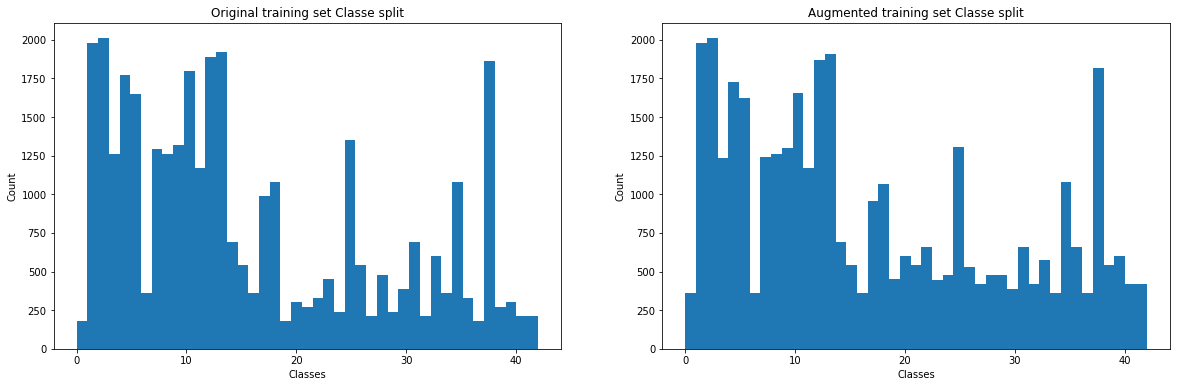

In [21]:
#Awesome we have now generated more imgages for our training set ! 

print("Original training set size : %s , label size : %s"%(X_train.shape,y_train.shape))
print("Augmented training set size : %s , label size : %s"%(X_train_aug.shape,y_train_aug.shape))

fig = plt.figure(figsize=(20, 6))

#train
plt.subplot(1,2,1)
plt.hist(y_train, bins=n_classes)
plt.title('Original training set Classe split')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.plot()

plt.subplot(1,2,2)
plt.hist(y_train_aug, bins=n_classes)
plt.title('Augmented training set Classe split')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.plot()

#### Normalize our images

The mean value for our training data was : 83.051829 and is now : 0.000000
The mean value for our test data was : 82.148460 and is now : 0.000000
The mean value for our validation data was : 83.556427 and is now : 0.000000


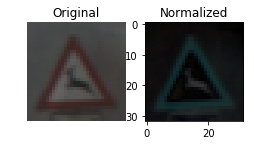

In [22]:
#normalize data to get centered value

X_train_normalized = (X_train_aug - X_train_aug.mean()) / (np.max(X_train_aug) - np.min(X_train_aug))
X_test_normalized = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))
X_valid_normalized = (X_valid - X_valid.mean()) / (np.max(X_valid) - np.min(X_valid))

#just to give an idea on what it looks like visualy , as imshow doesn't support negative values
X_train_normalized_for_plot = abs((X_train_aug - X_train_aug.mean()) / (np.max(X_train_aug) - np.min(X_train_aug)))
X_test_normalized_for_plot = abs((X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test)))
X_valid_normalized_for_plot = abs((X_valid - X_valid.mean()) / (np.max(X_valid) - np.min(X_valid)))

print("The mean value for our training data was : %f and is now : %f" % (X_train_aug.mean(),X_train_normalized.mean()))
print("The mean value for our test data was : %f and is now : %f" % (X_test.mean(),X_test_normalized.mean()))
print("The mean value for our validation data was : %f and is now : %f" % (X_valid.mean(),X_valid_normalized.mean()))

#sanity check for shapes
assert (X_train_aug.shape == X_train_normalized.shape)
assert (X_test.shape == X_test_normalized.shape)
assert (X_valid.shape == X_valid_normalized.shape)

plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(X_train_aug[567])
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Normalized')
plt.imshow(X_train_normalized_for_plot[567])

Our Images are now normalized !

#### Shuffle our data

In [23]:
#shuffle data
X_TRAIN, Y_TRAIN = shuffle(X_train_normalized, y_train_aug)
X_TEST, Y_TEST = shuffle(X_test_normalized, y_test)
X_VALID, Y_VALID = shuffle(X_valid_normalized, y_valid)

#Our Images are now shuffled !

### Model Architecture

As seen in the course LeNet-5 was a pioneering convolutional network designed by LeCun et al in 1998, for this project i tryed to implement more cutting edge architecture.


GoogleNet/Inception is the winner of the ILSVRC 2014 competition (a.k.a. Inception V1) from Google. It achieved a top-5 error rate of 6.67%! This was very close to human level performance.


The network used a CNN inspired by LeNet but implemented a novel element which is dubbed an inception module. It used batch normalization, image distortions and RMSprop. This module is based on several very small convolutions in order to drastically reduce the number of parameters. Their architecture consisted of a 22 layer deep CNN but reduced the number of parameters from 60 million (AlexNet) to 4 million.

##### GoogleLeNet Network architecture :

GoogleLeNet performance is mostly due to its inception module , which reduce the network parameter number , each inception module is as follow :

<img src="imgs/Inception.png",width=600,height=600>

Model architecture :

<img src="imgs/architecture.png",width=600,height=600>

Since the model require high computation power , we will go for a lightweight implementation of the model but based on the same core principle , our model will be as follow :

| Layer         		|      Input     | Output      |
|:---------------------:|:---------:|:-----------:| 
| Convolution       	| 32x32x3   | 28x28x6     |
| Max pooling	      	| 28x28x6   | 14x14x6     |
| Convolution       	| 14x14x6   | 10x10x16    |
| Max pooling	      	| 10x10x16  | 5x5x16      |
| Flatten				| 5x5x16    | 400         |
| Fully connected		|  400       | 120         |
| Fully connected		|  120       | 80          |
| Fully connected		|  80        | 43          |


Ref :https://medium.com/@siddharthdas_32104/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

Ref :https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf

Thankyou for liferlisiqi help that help me shape the network architecture

#### Model Architecture definition

In [26]:
def Inception(inputs, conv11_size, conv33_11_size, conv33_size,conv55_11_size, conv55_size, pool11_size):
    conv11 = layers.conv2d(inputs, conv11_size, [1, 1])
    conv33_reduce = layers.conv2d(inputs, conv33_11_size, [1, 1])
    conv33 = layers.conv2d(conv33_reduce, conv33_size, [3, 3])
    conv55_reduce = layers.conv2d(inputs, conv55_11_size, [1, 1])
    conv55 = layers.conv2d(conv55_reduce, conv55_size, [5, 5])
    pool_proj = layers.max_pool2d(inputs, [3, 3], stride = 1, padding='SAME')
    pool11 = layers.conv2d(pool_proj, pool11_size, [1, 1])
    return tf.concat([conv11, conv33, conv55, pool11], 3)

def GoogLeNet(inputs, dropout_keep_prob):
    
    conv1 = layers.conv2d(inputs, 64, [3, 3], stride = 2)     
    inception_2a = Inception(conv1, 64, 96, 128, 16, 32, 32) 
    inception_2b = Inception(inception_2a, 128, 128, 192, 32, 96, 64)
    pool2 = layers.max_pool2d(inception_2b, [3, 3]) 
    
    inception_3a = Inception(pool2, 192, 96, 208, 16, 48, 64)
    inception_3b = Inception(inception_3a, 160, 112, 224, 24, 64, 64) 
    pool3 = layers.max_pool2d(inception_3b, [3, 3]) # 3x3x512
    
    inception_4a = Inception(pool3, 256, 160, 320, 32, 128, 128)
    inception_4b = Inception(inception_4a, 384, 192, 384, 48, 128, 128)
    pool4 = layers.avg_pool2d(inception_4b, [3, 3], stride = 1) 

    reshape = tf.reshape(pool4, [-1, 1024])
    dropout = layers.dropout(reshape, dropout_keep_prob)
    logits = layers.fully_connected(dropout, 43, activation_fn=None)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

##### Tensorflow placeholders

In [83]:
# Lets Create our Tensorflow Placeholders

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

##### Model Hyperparameters

In [89]:
# Lets define our Hyperparameters
LEARNING_RATE = 4e-4
EPOCHS = 7
BATCH_SIZE = 128

##### Model definition ( architecture , loss function , optimizer)

In [90]:
# Apply our model 
logits = GoogLeNet(x, keep_prob)

#Define our Cross entropy and our loss function that will be minimized
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#Select the Tf optimizer for our model , we will choose AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
train_optimizer = optimizer.minimize(loss)

###### Model accuracy calculation

In [91]:
#Define a function to calculate the accuracy of our model
exact_answer = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(exact_answer, tf.float32))

def get_accuracy(X, Y):
    
    #get session
    sess = tf.get_default_session()
    
    #initialize our variable
    number_of_data = len(X)
    global_accuracy = 0
 
    for offset in range(0, number_of_data, BATCH_SIZE):
        batch_X, batch_Y = X[offset:offset + BATCH_SIZE], Y[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_X, y: batch_Y})
        global_accuracy += (accuracy * len(batch_X))
        output = global_accuracy / number_of_data
        
    return output

##### Train and validate our model 

In [92]:
#define our saver
saver = tf.train.Saver()

train_accuracy = []
valid_accuracy = []


with tf.Session() as sess:
    
    #get session details
    sess.run(tf.global_variables_initializer())
    
    #initialize our variable
    number_of_img = len(X_TRAIN)
     
    print("Training...")
    
    #Looping several time over the entire Dataset (EPOCHS)
    for i in range(EPOCHS):
        print("EPOCH :", i+1)
        X_train, y_train = shuffle(X_TRAIN, Y_TRAIN)
        total_train_acc = 0
        
        #Loop by BATCH_SIZE for computation efficiency
        for offset in range(0, number_of_img, BATCH_SIZE):
            
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_acc = sess.run([train_optimizer, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            total_train_acc += (train_acc * len(batch_x))
            
        #calculate the accuracy for the EPOCH 
        train_accuracy_to_save=total_train_acc / number_of_img
        train_accuracy.append(train_accuracy_to_save)
        valid_acc = get_accuracy(X_VALID, Y_VALID)
        valid_accuracy.append(valid_acc)
        print("Training Accuracy : {:.3f} , Valid Accuracy : {:.3f}".format(train_accuracy_to_save,valid_acc))
        
    #save session details
    saver.save(sess, './tensorflow_model/GoogleLeNet.ckpt')


Training...
EPOCH : 1
Training Accuracy : 0.202 , Valid Accuracy : 0.395
EPOCH : 2
Training Accuracy : 0.711 , Valid Accuracy : 0.877
EPOCH : 3
Training Accuracy : 0.960 , Valid Accuracy : 0.930
EPOCH : 4
Training Accuracy : 0.984 , Valid Accuracy : 0.959
EPOCH : 5
Training Accuracy : 0.988 , Valid Accuracy : 0.947
EPOCH : 6
Training Accuracy : 0.990 , Valid Accuracy : 0.929
EPOCH : 7
Training Accuracy : 0.992 , Valid Accuracy : 0.960


### Accuracy analysis and summary of our model


The following parameters have been used to train the model :

* Type of optimiser: AdamOptimizer
* Batch size: 128
* Training Epochs: 7
* Learning rate: 4e-4
* Loss function to minimize : crossentropy formula
* Dropout : 50%
##### Model final accuracy : 96.0% (can be improved with more epochs on more powerful workstation)

Train and validation accuracy : 


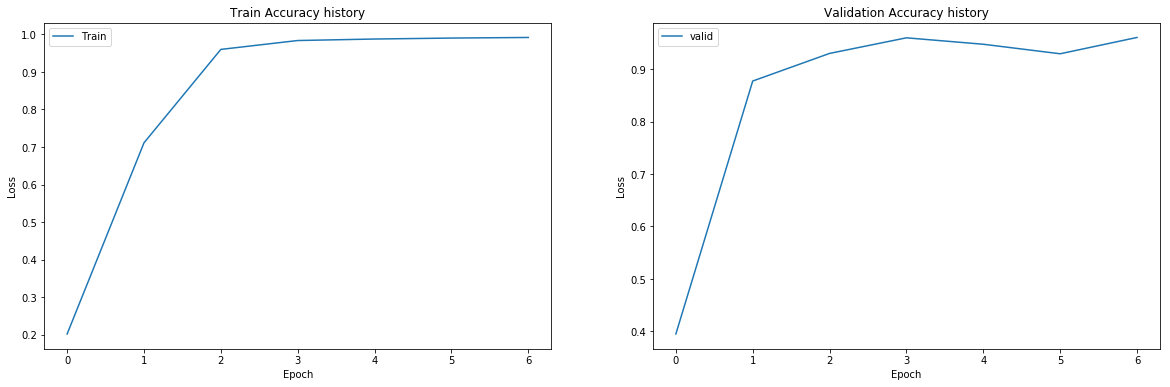

In [95]:
print("Train and validation accuracy : ")

fig = plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train')
plt.title('Train Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(valid_accuracy, label='valid')
plt.title('Validation Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load Images from internet

ref :https://www.google.fr/search?q=german+traffic+signs+img&rlz=1C1CHBF_frFR792FR792&source=lnms&tbm=isch&sa=X&ved=0ahUKEwi81Yi_ha3bAhUTkRQKHYJtBfcQ_AUICigB&biw=1536&bih=734

##### Here are images collected from google image

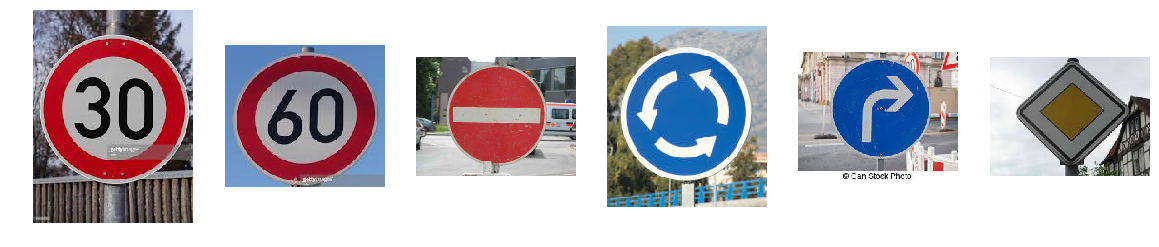

In [10]:
fig = plt.figure(figsize=(20, 6))
i=1
for filename in glob.glob('./german_traffic_signs_samples/*.jpg'):
    img = plt.imread(filename)
    plt.subplot(1, 6, i)
    plt.imshow(img)
    plt.axis('off')
    i=i+1

##### Let normalize and resize them

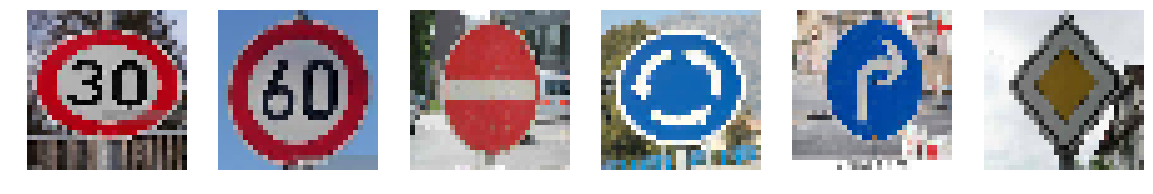

In [128]:
fig = plt.figure(figsize=(20, 6))
image_from_internet = []
i=1

for filename in glob.glob('./german_traffic_signs_samples/*.jpg'):
    img = plt.imread(filename)
    img_32= cv2.resize(img,(32, 32), interpolation = cv2.INTER_CUBIC)
    image_from_internet.append(img_32)
    plt.subplot(1, 6, i)
    plt.imshow(img_32)
    plt.axis('off')
    i=i+1

In [129]:
image_from_internet = np.array(image_from_internet)
image_from_internet_normalized = (image_from_internet - image_from_internet.mean()) / (np.max(image_from_internet) - np.min(image_from_internet))
print("Images normalized with new mean =",np.mean(image_from_internet_normalized))

Images normalized with new mean = -1.0793834961633467e-17


### Load our trained model

In [119]:
saver = tf.train.import_meta_graph('./tensorflow_model/GoogleLeNet.ckpt.meta')

### Predict the Sign Type for Each Image an  accuracy analysis

INFO:tensorflow:Restoring parameters from ./tensorflow_model/GoogleLeNet.ckpt
Real Classe for images      : [1, 3, 17, 40, 33, 12]
Predicted Classe for images : [ 1  3 17 40 33 12]
Accuracy = 1.000


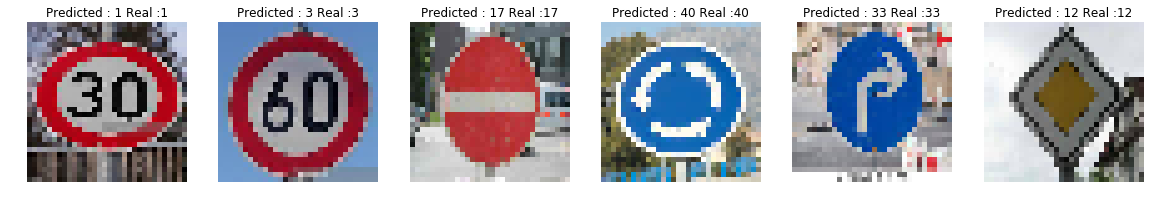

In [133]:
hand_label_for_images = [1,3,17,40,33,12]

with tf.Session() as sess:
    
    #restore the session
    saver.restore(sess, './tensorflow_model/GoogleLeNet.ckpt')
    
    #get accuracy
    accuracy = get_accuracy(image_from_internet_normalized, hand_label_for_images)
   
    
    logits_value = sess.run(logits, feed_dict={x: image_from_internet_normalized})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
#get prediction    
predict = probabilities.argmax(axis=1)

#output the result
print("Real Classe for images      :",hand_label_for_images)
print("Predicted Classe for images :",predict)
print("Accuracy = {:.3f}".format(accuracy)) 

#plot the result
fig = plt.figure(figsize=(20, 6))
for i in range(len(hand_label_for_images)):
    plt.subplot(1, 6, i+1)
    plt.imshow(image_from_internet[i])
    plt.axis('off')
    plt.title("Predicted : %s Real :%s" % (predict[i],hand_label_for_images[i]))


### Awesome our model predicted with a 100% accuracy on this image set !

### Lets dig a deep deeper in our model prediction and lets Output the Top 5 Softmax Probabilities For Each Image Found on the Web

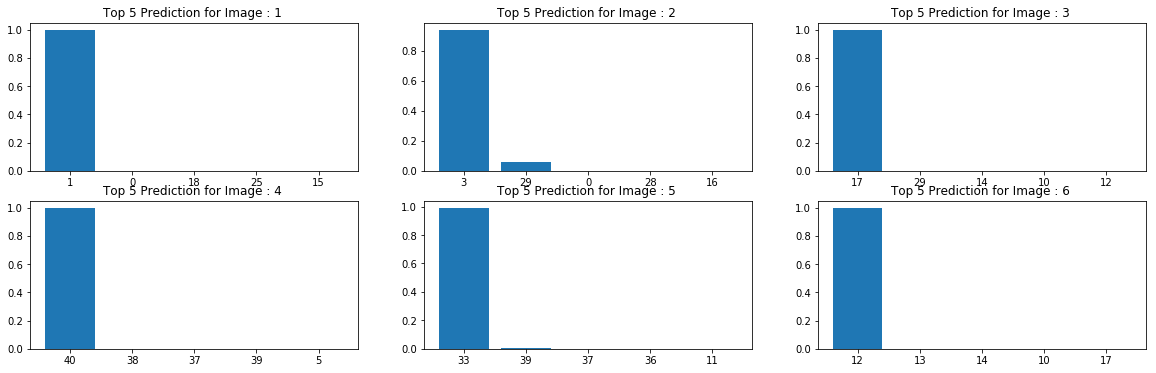

In [148]:
with tf.Session() as sess:
    top_k = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))
    
    fig = plt.figure(figsize=(20, 6))

    for i in range(len(hand_label_for_images)):
        plt.subplot(2, 3, i+1)
        plt.title("Top 5 Prediction for Image : %i " % (i+1))         
        plt.bar(range(5), top_k.values[i])    
        plt.xticks(range(5), top_k.indices[i])  
    plt.show()

   Sounds like all the prediction were straighforward for the model expect for image 2 where the model predict a low probability for the 60 kmh speed limit to be a class 29 panel, strange as these different panel have different shapes. 

### Project Writeup

A complete writeup for the project can be found in the readme file.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")